# Assessent of mitosis-mediated phototoxicity temporal footprint

This notebook assumes that you already processed the videos using StarDist or any other segmentation method. It expects `.tif` video files with the instance mask of each identified cell (*i.e.*, the mask of each cell has a different value). Tracking of the segmented cells is not needed.

The data is assumed to be organised in a folders as follows. The Subcategories are the ones that the code uses to display the data. The labels will be identical to the folder name, so same conditions should always have the same folder name.

   ```
   general_path:
   
   -Raw-images (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcaegory-00]
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01]
        ...
        
    -Masks (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcaegory-00]
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01]
        ...
   ```

## 0. Import all the required dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from photofitt.analysis import count_mitosis_all, quantify_peaks, compare_peaks
from photofitt.display import display_data_from_masks, conditions, info_wrt_peak, mitosis, size_change_wrt_peak
from photofitt.analysis import extract_gaussian_params

### 0.1 Provide some input information

In [8]:
masks_path = "/Users/esti/Documents/PROYECTOS/PHX/mitosis_mediated_data_itqb_3/CHO/masks/scaled_1.5709_results/stardist_prob03"
frame_rate = 4 # The time gap we will use to compute all the metrics
output_path = "/Users/esti/Documents/PROYECTOS/PHX/DOCS/MANUSCRIPT/code-output"

## 1. Count the number of mitoses

In [ ]:
data = count_mitosis_all(masks_path, frame_rate = frame_rate)
# save the information
data.to_csv(os.path.join(output_path, "mitosis_counting.csv"))

### 1.1 Display the results

The next code will create a bunch of plots considering all the conditions and experimental replicas. By default, it will export the plots as .png, but you can also specify the `graph_format='png'` in the function.

We will show afterwards how to plot this data for one single condition.

In [ ]:
# If you stored the data in a previous session, you can load it again as follows:
path_data = "/Users/esti/Documents/PROYECTOS/PHX/DOCS/MANUSCRIPT/code-output/data_mitosis_real.csv"
data = pd.read_csv(path_data)

# Control the order of the legend and the format to export the plots.
# If the order is unknown, let it as huer_order=None
hue_order = ['Control-sync', 'Synchro', 'UV25ms', 'UV50ms', 'UV100ms', 'UV200ms', 'UV400ms', 'UV800ms',
             'UV01sec', 'UV05sec', 'UV10sec', 'UV15sec', 'UV20sec', 'UV25sec'] 
graph_format = 'png'

# Plot the data
display_data_from_masks(data, output_path, frame_rate=frame_rate,
                        graph_format=graph_format, hue_order=hue_order)

#### 1.1.1 Plot all the experimental data for one single condition

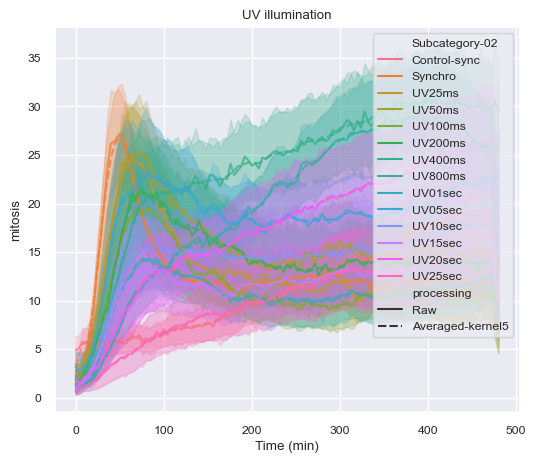

In [41]:
## Information for the plot
group = "WL UV - high density"
data_g = data[data["Subcategory-01"]==group].reset_index(drop=True)
title = "UV illumination"
condition = "Subcategory-02"
y_var = "mitosis" # name of the variable to display in the plot.
name = "{0}_{1}.png".format(group, y_var) # name we want to give to the plot
hue_order = ['Control-sync', 'Synchro', 'UV25ms', 'UV50ms', 'UV100ms', 'UV200ms', 'UV400ms', 'UV800ms',
             'UV01sec', 'UV05sec', 'UV10sec', 'UV15sec', 'UV20sec', 'UV25sec']
conditions(data_g, y_var, title, condition, output_path, name,
                style_condition="processing", hue_order=hue_order)

## 2. Calculate the time point with the peak of identified mitoses
### 2.1. Estimate the cell size temporal distribution

In [ ]:
# We still use the data calculated in 1. We use the raw data, but one could used the smooth data.
data = data[data["processing"]=="Raw"].reset_index(drop=True)

## TODO: This filtering is needed for us but should dissapear from the notebook
aux = data[data["Subcategory-02"] == 'UV1000ms']
data.loc[aux.index.to_list(), ["Subcategory-02"]] = ['UV01sec']

## Estimate statistical parameters for the cell size temporal distribution
variable = "cell_size"
distribution_data = extract_gaussian_params(data, variable)
# We save the data so we can use it latter.
distribution_data.to_csv(os.path.join(output_path, "cell_size_statistics.csv"))


In [ ]:
# Load the computed data:
distribution_data = pd.read_csv(os.path.join(output_path, "cell_size_statistics.csv"))

groups_comparison = np.unique(data["Subcategory-01"])

# Specified to ensure that all the plots have the same distribution of colors.
conditions = ['Control-sync', 'Synchro', 'UV25ms', 'UV50ms', 'UV100ms',
              'UV200ms', 'UV400ms', 'UV800ms', 'UV01sec',
              'UV05sec',  'UV10sec', 'UV15sec', 'UV20sec', 'UV25sec'] 

for c in groups_comparison:
    output_path_plots = os.path.join(output_path, c)
    os.makedirs(output_path_plots, exist_ok=True)
    # Filter the data for each group of the analysis.
    data_c = data[data["Subcategory-01"]==c].reset_index(drop=True)
    plot_mitosis(data_c, output_path_plots, conditions, "mitosis")
    
    # Integrate the information about the temporal peaks of mitosis
    data_c = quantify_peaks(data_c, "mitosis")
    plot_info_wrt_peak(data_c, conditions, conditions, output_path_plots)
    
    # Obtain statistics about the data.
    aux = distribution_data[distribution_data["Subcategory-01"] == c].reset_index(drop=True)
    # aux["ratio"] = aux["GaussianMixtureCovariance_0"] / aux["GaussianMixtureCovariance_1"]
    # aux["subt_0"] = abs(aux["average"] - aux["GaussianMixtureMean_0"])
    # aux["subt_1"] = abs(aux["average"] - aux["GaussianMixtureMean_1"])
    plot_mitosis(aux, output_path_plots, conditions, "average")
    
    # Display some of these statistics
    values = ["average", "derivative-average", "variance", 'GaussianMixtureMean_0', 'GaussianMixtureMean_1',
              'GaussianMixtureCovariance_0', 'GaussianMixtureCovariance_1']
    for v in values:
        print(v)
        plot_conditions(aux, v, "Cell size {}".format(v), "Subcategory-02", output_path_plots,
                        "size_{0}_{1}.png".format(v, c), style_condition="Subcategory-01", hue_order=conditions)
    
    # Compare the temporal peaks between groups and display them
    peak_dataframe = compare_peaks(data_c, aux, peak_percentile=75)
    plot_size_chnage_wrt_peak(peak_dataframe, conditions, "mitosis_t", np.unique(aux["Subcategory-00"]),
                              output_path_plots, y_lim=[0, 300])

## 3. Calculate the temporal dynamics and distorsions of cell activity.

In [2]:
images_path = "/Volumes/TOSHIBA EXT/ITQB PTX DATA/ANALYSIS/CHO-UNSYNCH"
frame_rate = 4 # The time gap we will use to compute all the metrics
output_path = "/Users/esti/Documents/PROYECTOS/PHX/mitosis_mediated_data_itqb_3/CHO-UNSYNCH"

## Parameters for motion method estimation
method="intensity"
folder = "motion_clahe-{}".format(method)
condition="unsynchro"

### 3.1 Quantify cell motion and save the values in a .csv file

In [11]:
from photofitt.analysis import extract_motion

## The function will store the values as it is calculating them to avoid losing tehm in case the system crashes.
if not os.path.exists(os.path.join(output_path, folder)):
    os.mkdir(os.path.join(output_path, folder))

motion_metrics = extract_motion(images_path, method=method, save_steps=False, enhance_contrast=True,
                                            output_path=os.path.join(output_path, folder), condition=None)
## Save the results
motion_metrics.to_csv(os.path.join(output_path, folder, "data_motion_{0}_{1}.csv".format(method, condition)))

['20230601_630_unsync_day', '20230526_630_unsync', '20230524_UV_unsync', '20230525_475_unsync_day', '20230525_475_unsync_night', '20230524_UV_unsync_night']
['WL 630 - high density']
['25ms', '50ms', '100ms', '200ms', '400ms', '800ms', 'control-00ms']
['CHO_630_live-02-Scene-11-P2-A02.tif', 'CHO_630_live-02-Scene-12-P1-A02.tif', 'CHO_630_live-02-Scene-13-P3-A02.tif', 'CHO_630_live-02-Scene-14-P9-A02.tif', 'CHO_630_live-02-Scene-15-P7-A02.tif', 'CHO_630_live-02-Scene-16-P4-A02.tif', 'CHO_630_live-02-Scene-17-P6-A02.tif', 'CHO_630_live-02-Scene-18-P5-A02.tif', 'CHO_630_live-02-Scene-19-P10-A02.tif', 'CHO_630_live-02-Scene-20-P8-A02.tif']
CHO_630_live-02-Scene-11-P2-A02.tif
CHO_630_live-02-Scene-12-P1-A02.tif
CHO_630_live-02-Scene-13-P3-A02.tif
CHO_630_live-02-Scene-14-P9-A02.tif
CHO_630_live-02-Scene-15-P7-A02.tif
CHO_630_live-02-Scene-16-P4-A02.tif
CHO_630_live-02-Scene-17-P6-A02.tif
CHO_630_live-02-Scene-18-P5-A02.tif
CHO_630_live-02-Scene-19-P10-A02.tif
CHO_630_live-02-Scene-20-P8-A02

CHO_unsync_630-live-01-Scene-32-P2-A04.tif
CHO_unsync_630-live-01-Scene-33-P6-A04.tif
CHO_unsync_630-live-01-Scene-34-P1-A04.tif
CHO_unsync_630-live-01-Scene-35-P4-A04.tif
CHO_unsync_630-live-01-Scene-36-P7-A04.tif
CHO_unsync_630-live-01-Scene-37-P8-A04.tif
CHO_unsync_630-live-01-Scene-38-P3-A04.tif
CHO_unsync_630-live-01-Scene-39-P5-A04.tif
CHO_unsync_630-live-01-Scene-40-P10-A04.tif
['CHO_unsync_630-live-01-Scene-61-P7-B02.tif', 'CHO_unsync_630-live-01-Scene-62-P1-B02.tif', 'CHO_unsync_630-live-01-Scene-63-P5-B02.tif', 'CHO_unsync_630-live-01-Scene-64-P3-B02.tif', 'CHO_unsync_630-live-01-Scene-65-P8-B02.tif', 'CHO_unsync_630-live-01-Scene-66-P9-B02.tif', 'CHO_unsync_630-live-01-Scene-67-P10-B02.tif', 'CHO_unsync_630-live-01-Scene-68-P4-B02.tif', 'CHO_unsync_630-live-01-Scene-69-P2-B02.tif', 'CHO_unsync_630-live-01-Scene-70-P6-B02.tif']
CHO_unsync_630-live-01-Scene-61-P7-B02.tif
CHO_unsync_630-live-01-Scene-62-P1-B02.tif
CHO_unsync_630-live-01-Scene-63-P5-B02.tif
CHO_unsync_630-live-0

CHO_unsync_UV-live-01-Scene-66-P3-B02.tif
CHO_unsync_UV-live-01-Scene-67-P6-B02.tif
CHO_unsync_UV-live-01-Scene-68-P5-B02.tif
CHO_unsync_UV-live-01-Scene-69-P8-B02.tif
CHO_unsync_UV-live-01-Scene-70-P9-B02.tif
['CHO_unsync_UV-live-01-Scene-51-P9-B03.tif', 'CHO_unsync_UV-live-01-Scene-52-P4-B03.tif', 'CHO_unsync_UV-live-01-Scene-53-P7-B03.tif', 'CHO_unsync_UV-live-01-Scene-54-P3-B03.tif', 'CHO_unsync_UV-live-01-Scene-55-P10-B03.tif', 'CHO_unsync_UV-live-01-Scene-56-P8-B03.tif', 'CHO_unsync_UV-live-01-Scene-57-P6-B03.tif', 'CHO_unsync_UV-live-01-Scene-58-P2-B03.tif', 'CHO_unsync_UV-live-01-Scene-59-P1-B03.tif', 'CHO_unsync_UV-live-01-Scene-60-P5-B03.tif']
CHO_unsync_UV-live-01-Scene-51-P9-B03.tif
CHO_unsync_UV-live-01-Scene-52-P4-B03.tif
CHO_unsync_UV-live-01-Scene-53-P7-B03.tif
CHO_unsync_UV-live-01-Scene-54-P3-B03.tif
CHO_unsync_UV-live-01-Scene-55-P10-B03.tif
CHO_unsync_UV-live-01-Scene-56-P8-B03.tif
CHO_unsync_UV-live-01-Scene-57-P6-B03.tif
CHO_unsync_UV-live-01-Scene-58-P2-B03.tif
C

CHO_unsync_UV-live-01-Scene-62-P7-B02.tif
CHO_unsync_UV-live-01-Scene-63-P2-B02.tif
CHO_unsync_UV-live-01-Scene-64-P4-B02.tif
CHO_unsync_UV-live-01-Scene-65-P3-B02.tif
CHO_unsync_UV-live-01-Scene-66-P1-B02.tif
CHO_unsync_UV-live-01-Scene-67-P6-B02.tif
CHO_unsync_UV-live-01-Scene-68-P5-B02.tif
CHO_unsync_UV-live-01-Scene-69-P8-B02.tif
CHO_unsync_UV-live-01-Scene-70-P9-B02.tif
['CHO_unsync_UV-live-01-Scene-51-P4-B03.tif', 'CHO_unsync_UV-live-01-Scene-52-P6-B03.tif', 'CHO_unsync_UV-live-01-Scene-53-P7-B03.tif', 'CHO_unsync_UV-live-01-Scene-54-P3-B03.tif', 'CHO_unsync_UV-live-01-Scene-55-P9-B03.tif', 'CHO_unsync_UV-live-01-Scene-56-P8-B03.tif', 'CHO_unsync_UV-live-01-Scene-57-P2-B03.tif', 'CHO_unsync_UV-live-01-Scene-58-P10-B03.tif', 'CHO_unsync_UV-live-01-Scene-59-P1-B03.tif', 'CHO_unsync_UV-live-01-Scene-60-P5-B03.tif']
CHO_unsync_UV-live-01-Scene-51-P4-B03.tif
CHO_unsync_UV-live-01-Scene-52-P6-B03.tif
CHO_unsync_UV-live-01-Scene-53-P7-B03.tif
CHO_unsync_UV-live-01-Scene-54-P3-B03.tif
CH

unsync_CHO_day_475_snap-prelive-02-Scene-42-P9-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-43-P2-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-44-P1-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-45-P4-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-46-P5-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-47-P6-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-48-P8-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-49-P3-B04.tif
unsync_CHO_day_475_snap-prelive-02-Scene-50-P7-B04.tif
['unsync_CHO_day_475_snap-prelive-02-Scene-01-P1-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-02-P5-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-03-P2-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-04-P9-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-05-P6-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-06-P3-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-07-P4-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Scene-08-P10-A01.tif', 'unsync_CHO_day_475_snap-prelive-02-Sce

CHO_unsync_UV-live-01-Scene-52-P6-B03.tif
CHO_unsync_UV-live-01-Scene-53-P7-B03.tif
CHO_unsync_UV-live-01-Scene-54-P3-B03.tif
CHO_unsync_UV-live-01-Scene-55-P9-B03.tif
CHO_unsync_UV-live-01-Scene-56-P8-B03.tif
CHO_unsync_UV-live-01-Scene-57-P2-B03.tif
CHO_unsync_UV-live-01-Scene-58-P10-B03.tif
CHO_unsync_UV-live-01-Scene-59-P1-B03.tif
CHO_unsync_UV-live-01-Scene-60-P5-B03.tif
['CHO_unsync_UV-live-01-Scene-41-P9-B04.tif', 'CHO_unsync_UV-live-01-Scene-42-P10-B04.tif', 'CHO_unsync_UV-live-01-Scene-43-P5-B04.tif', 'CHO_unsync_UV-live-01-Scene-44-P2-B04.tif', 'CHO_unsync_UV-live-01-Scene-45-P8-B04.tif', 'CHO_unsync_UV-live-01-Scene-46-P7-B04.tif', 'CHO_unsync_UV-live-01-Scene-47-P4-B04.tif', 'CHO_unsync_UV-live-01-Scene-48-P1-B04.tif', 'CHO_unsync_UV-live-01-Scene-49-P3-B04.tif', 'CHO_unsync_UV-live-01-Scene-50-P6-B04.tif']
CHO_unsync_UV-live-01-Scene-41-P9-B04.tif
CHO_unsync_UV-live-01-Scene-42-P10-B04.tif
CHO_unsync_UV-live-01-Scene-43-P5-B04.tif
CHO_unsync_UV-live-01-Scene-44-P2-B04.tif


In [ ]:
from photofitt.analysis import extract_motion

## The function will store the values as it is calculating them to avoid losing tehm in case the system crashes.
if not os.path.exists(os.path.join(output_path, folder)):
    os.mkdir(os.path.join(output_path, folder))

motion_metrics = extract_motion(images_path, method=method, save_steps=False, enhance_contrast=True, save_steps=True,
                                            output_path=os.path.join(output_path, folder), condition=None)
## Save the results
motion_metrics.to_csv(os.path.join(output_path, folder, "data_motion_{0}_{1}.csv".format(method, condition)))


### Display the results

       frame  time_variance            Subcategory-00         Subcategory-01  \
0        0.0       0.000330   20230601_630_unsync_day  WL 630 - high density   
1        4.0       0.000382   20230601_630_unsync_day  WL 630 - high density   
2        8.0       0.000452   20230601_630_unsync_day  WL 630 - high density   
3       12.0       0.000515   20230601_630_unsync_day  WL 630 - high density   
4       16.0       0.000643   20230601_630_unsync_day  WL 630 - high density   
...      ...            ...                       ...                    ...   
57595  460.0       0.000135  20230524_UV_unsync_night   WL UV - high density   
57596  464.0       0.000132  20230524_UV_unsync_night   WL UV - high density   
57597  468.0       0.000115  20230524_UV_unsync_night   WL UV - high density   
57598  472.0       0.000114  20230524_UV_unsync_night   WL UV - high density   
57599  476.0       0.000122  20230524_UV_unsync_night   WL UV - high density   

      Subcategory-02                   

/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:36: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  sns.lineplot(x="frame", y=y_var, hue=hue, style=style, data=data, palette=sns.color_palette("husl", 14),
/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x="frame", y=y_var, style=style, data=data, palette=sns.color_palette("husl", 14),
/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:36: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  sns.lineplot(x="frame", y=y_var, hue=hue, style=style, data=data, palette=sns.color_palette("husl", 14),
/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:42: UserWarning: Ignoring `palette`

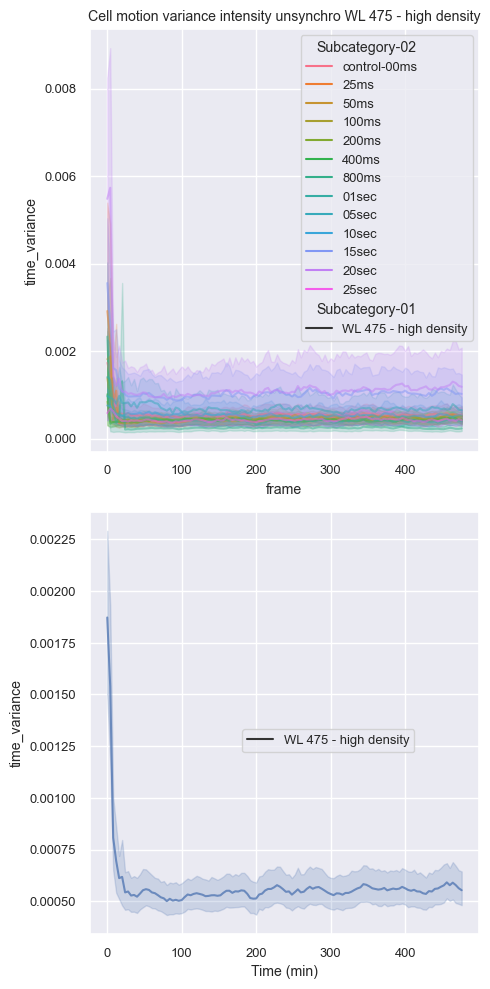

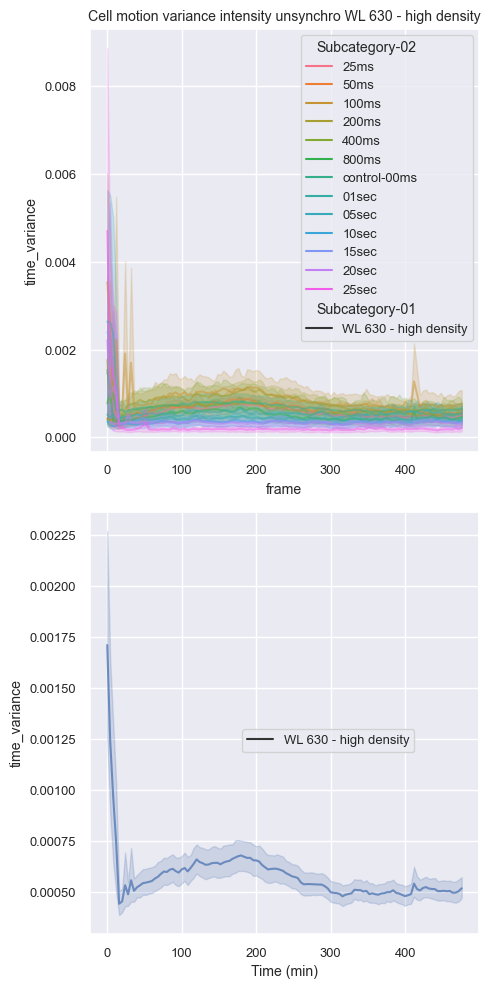

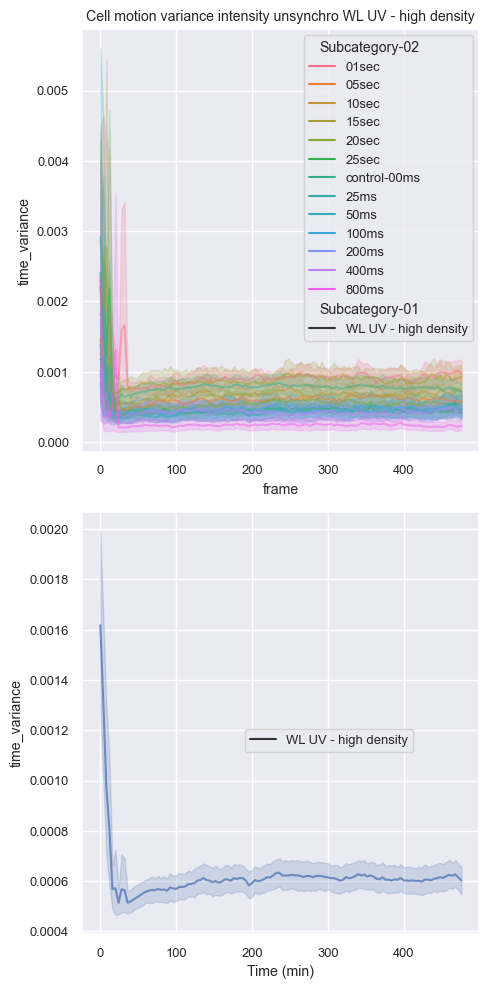

In [17]:
from photofitt.display import conditions_with_aggregates
from photofitt.analysis import cummulative_motion

hue_order = ['control-00ms', '25ms', '50ms', '100ms', '200ms', '400ms', '800ms',
             '01sec', '05sec', '10sec', '15sec', '20sec', '25sec'] 


motion_metrics.to_csv(os.path.join(output_path, folder, "data_motion_{0}_{1}.csv".format(method, condition)))
wavelength = np.unique(motion_metrics["Subcategory-01"])

for w in wavelength:
    motion_w = motion_metrics[motion_metrics["Subcategory-01"]==w].reset_index(drop=True)
    motion_w.to_csv(os.path.join(output_path, folder, "data_motion_{0}_{1}_{2}.csv".format(method, condition, w)))
    
    conditions_with_aggregates(motion_w, "Cell motion",
                               "Cell motion variance {0} {1} {2}".format(method, condition, w),
                               os.path.join(output_path, folder),
                               "motion_variance_{0}_{1}_{2}.png".format(method, condition, w),
                               hue="Subcategory-02", style="Subcategory-01")
    
    motion_w_dataframe, motion_w = cummulative_motion(motion_w, use_starting_point=None, starting_point=0)
    
    y_var = "Cummulative cell motion"
    format_extension = 'pdf'
    name = "cell_cummulative_motion_from0.{}".format(format_extension)

    #display.plot_conditions(dynamics_metrics, y_var, "Cummulative cell growth after mitosis", "Subcategory-02", 
    #                        output_path, name, style_condition="Subcategory-01", hue_order=hue_order)

    fig = plt.figure(figsize=(4, 5), constrained_layout=True)
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.plotting_context("paper")
    sns.set_theme(style="ticks", rc=custom_params)
    sns.set(font_scale=0.85)
    # Plot the results per category
    sns.lineplot(x="frame", y=y_var, hue="Subcategory-02", data=motion_w,
                 palette=sns.color_palette("CMRmap_r", 17), linewidth=1.5, alpha=0.75, hue_order=hue_order)
    # plt.ylabel(y_label)
    plt.xlabel("Time (min)")
    plt.yscale("linear")
    plt.title(f"{w}")
    #plt.legend(loc='upper right')
    format_extension = name.split(".")[-1]
    format_extension = 'pdf'
    name = "cell_cummulative_motion_{0}.{1}".format(w, format_extension)
    fig.savefig(os.path.join(output_path, folder, name), format=format_extension, transparent=True)
    format_extension = 'png'
    name = "cell_cummulative_motion_{0}.{1}".format(w, format_extension)
    fig.savefig(os.path.join(output_path, folder, name), format=format_extension, transparent=True)

/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:79: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  sns.lineplot(x="frame", y=y_var, hue=condition, data=data,
/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:79: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  sns.lineplot(x="frame", y=y_var, hue=condition, data=data,
/Users/esti/mambaforge/envs/photofitt/lib/python3.9/site-packages/photofitt/display/plots.py:79: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  sns.lineplot(x="frame", y=y_var, hue=condition, data=data,


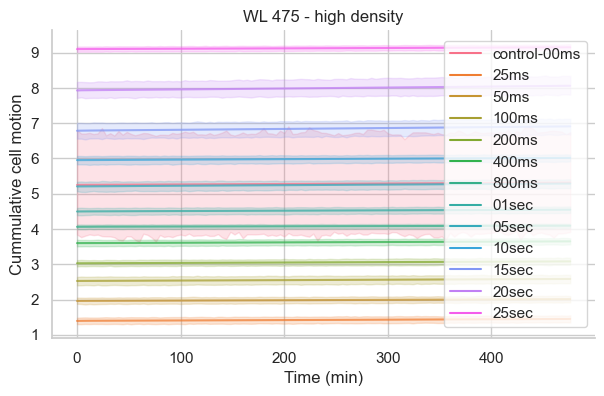

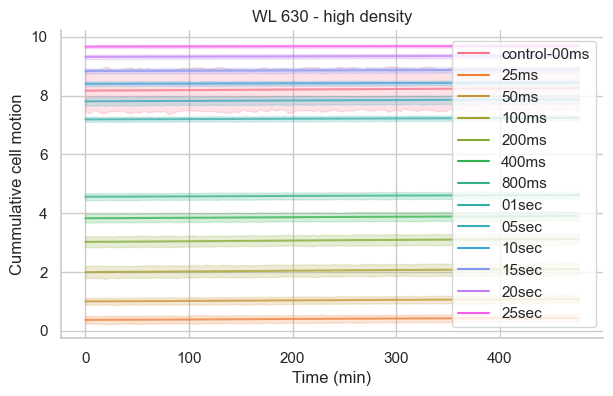

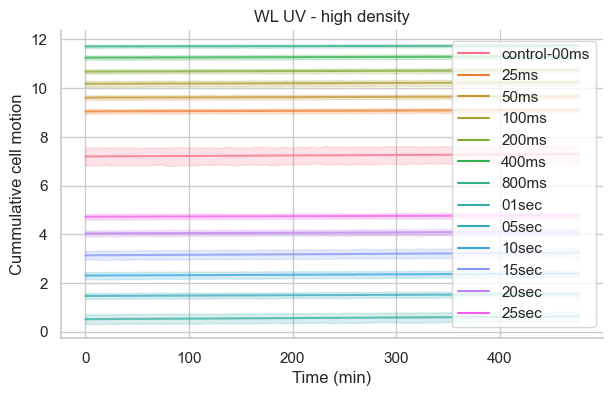

In [19]:
hue_order = ['control-00ms', '25ms', '50ms', '100ms', '200ms', '400ms', '800ms',
             '01sec', '05sec', '10sec', '15sec', '20sec', '25sec'] 

y_var = "Cummulative cell motion"
format_extension = 'png'
name = "cell_cummulative_motion_from0.{}".format(format_extension)


motion_metrics = pd.read_csv(os.path.join(output_path, folder, "data_motion_{0}_{1}.csv".format(method, condition)))
wavelength = np.unique(motion_metrics["Subcategory-01"])
motion_metrics = motion_metrics.rename(columns={'time_variance': 'Cell motion'})

for w in wavelength:
    motion_w = motion_metrics[motion_metrics["Subcategory-01"]==w].reset_index(drop=True)
    motion_w_dataframe, motion_w = cummulative_motion(motion_w, use_starting_point=None, starting_point=0)
    title = f"{w}"
    name = "cell_cummulative_motion_{0}.{1}".format(w, format_extension)
    conditions(motion_w, y_var, title, "Subcategory-02", os.path.join(output_path, folder), name,
               hue_order=hue_order, style_condition=None)